# H&E usage
The purpose of this notebook is to showcase how to perform basic analyses of H&E data and eventually combine it other modalities (transcriptomics or multiplex imaging).

You will need the `wsi` extra of sopa for this tutorial, i.e. `pip install sopa[wsi]`

In [1]:
import sopa
import spatialdata
import spatialdata_plot

For this tutorial, we will use [this Xenium pancreatic cancer dataset](https://www.10xgenomics.com/datasets/pancreatic-cancer-with-xenium-human-multi-tissue-and-cancer-panel-1-standard). In particular, it has H&E attached to the spatial transcriptomics. You can also use the H&E alone by using the `sopa.io.wsi` reader.

To keep it simple, we will assume the Sopa pipeline has already been run, and for the sake of this tutorial we will directly use the Xenium default segmentation (`cells_boundaries=True`). If you use your own data after running Sopa, simply read your data with the `spatialdata.read_zarr` function.

In [2]:
# here, we will directly open the processed Xenium directory
sdata = sopa.io.xenium("data/xenium/Xenium_V1_hPancreas_Cancer_Add_on_FFPE_outs", cells_boundaries=True)

INFO     reading data/xenium/Xenium_V1_hPancreas_Cancer_Add_on_FFPE_outs/cell_feature_matrix.h5                    


/Users/quentinblampey/mambaforge/envs/sopa/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  warnings.warn(msg, FutureWarning)


INFO     Transposing `data` of type: <class 'dask.array.core.Array'> to ('c', 'y', 'x').                           


/Users/quentinblampey/dev/_external/spatialdata/src/spatialdata/_core/spatialdata.py:167: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)
/Users/quentinblampey/dev/_external/spatialdata/src/spatialdata/_core/_elements.py:62: UserWarning: Key `morphology_mip` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)
/Users/quentinblampey/dev/_external/spatialdata/src/spatialdata/_core/_elements.py:62: UserWarning: Key `morphology_focus` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)
/Users/quentinblampey/dev/_external/spatialdata/src/spatialdata/_core/_elements.py:62: UserWarning: Key `he_image` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)


When using Xenium data, your H&E image is already aligned. If it's not the case, or if you have another technology, then you can align the H&E image as in [this tutorial](../align/).

Here, we see that the H&E image is called `"he_image"`:

For efficiency in the tutorial, we will write the data on-disk (`.zarr` directory):

In [3]:
sdata.write("Xenium_V1_hPancreas_Cancer_Add_on_FFPE_outs.zarr")
sdata = spatialdata.read_zarr("Xenium_V1_hPancreas_Cancer_Add_on_FFPE_outs.zarr")

/Users/quentinblampey/mambaforge/envs/sopa/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [4]:
# (optional) the new spatial elements will not be saved on disk automatically
sopa.settings.auto_save_on_disk = False

## Tissue segmentation

Optionally, we can run tissue segmentation. This will create new polygons saved inside `sdata['region_of_interest']`.

> NB: by default, Sopa knows it should use `"he_image"` for tissue segmentation. Depending on your data, you might need to provide the `image_key` argument.

For more details, refer to the documentation of [`sopa.segmentation.tissue`](../../api/segmentation/#sopa.segmentation.tissue).

In [5]:
sopa.segmentation.tissue(sdata, expand_radius_ratio=0)

[INFO] (sopa.segmentation._tissue) Using image_key='he_image' and mode='saturation' as default


The tissue segmentation can be shown as below: 

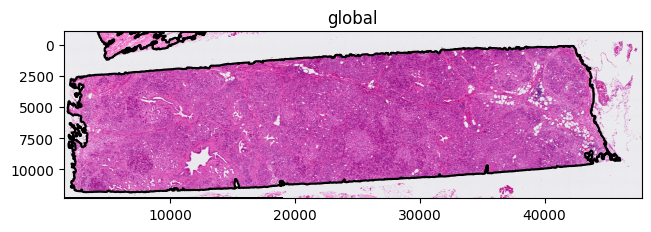

In [6]:
sdata\
    .pl.render_images("he_image", scale="scale3")\
    .pl.render_shapes("region_of_interest", outline_alpha=1, fill_alpha=0)\
    .pl.show("global")

## Patches embeddings and clusters

It is common to embed H&E patches using a computer vision model. Here, we use a computer vision model to embed patches. On the following example, we compute embeddings for patches of width `250` pixels at the level 1 (i.e., the first sub-resolution image).

You can adjust the level to get different resolutions. For instance, `level=0, patch_width=100` would produce a resolution of about one cell per patch.

See the documentation of [`sopa.patches.compute_embeddings`](../../api/patches/#sopa.patches.compute_embeddings) for more details.

In [7]:
sopa.patches.compute_embeddings(sdata, "histo_ssl", patch_width=256, level=1)

[INFO] (sopa.patches.infer) Processing 4106 patches extracted from level 1
100%|██████████| 129/129 [03:11<00:00,  1.48s/it]
[INFO] (sopa.patches._patches) 4106 patches were added to sdata['embeddings_patches']


Now, we have a key `'histo_ssl_embeddings'` containing the embeddings (as an image), and `'embeddings_patches'` containing the geometries of the patches.

In [8]:
sdata

SpatialData object, with associated Zarr store: /Users/quentinblampey/dev/sopa/docs/tutorials/Xenium_V1_hPancreas_Cancer_Add_on_FFPE_outs.zarr
├── Images
│     ├── 'he_image': DataTree[cyx] (3, 71883, 20562), (3, 35941, 10281), (3, 17970, 5140), (3, 8985, 2570), (3, 4492, 1285)
│     ├── 'histo_ssl_embeddings': DataArray[cyx] (512, 141, 41)
│     ├── 'morphology_focus': DataTree[cyx] (1, 13752, 48274), (1, 6876, 24137), (1, 3438, 12068), (1, 1719, 6034), (1, 859, 3017)
│     └── 'morphology_mip': DataTree[cyx] (1, 13752, 48274), (1, 6876, 24137), (1, 3438, 12068), (1, 1719, 6034), (1, 859, 3017)
├── Points
│     └── 'transcripts': DataFrame with shape: (<Delayed>, 10) (3D points)
├── Shapes
│     ├── 'cell_boundaries': GeoDataFrame shape: (190965, 1) (2D shapes)
│     ├── 'embeddings_patches': GeoDataFrame shape: (4106, 3) (2D shapes)
│     └── 'region_of_interest': GeoDataFrame shape: (2, 1) (2D shapes)
└── Tables
      └── 'table': AnnData (190965, 474)
with coordinate systems:
    ▸

Then, clustering can be run on the patches embeddings. This will add a `"cluster"` column to the a `GeoDataFrame` under `sdata["embeddings_patches"]` (defined in the previous line).

See the documentation of [`sopa.patches.cluster_embeddings`](../../api/patches/#sopa.patches.cluster_embeddings) for more details.

In [9]:
sopa.patches.cluster_embeddings(sdata, 'histo_ssl_embeddings')

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [10]:
sdata["embeddings_patches"]

,geometry,bboxes,ilocs,cluster
0,"POLYGON ((5344.52 256, 5344.52 248.035, 5344.5...","[5120, 0, 5376, 256]","[20, 0]",0
1,"POLYGON ((5592.508 256, 5584.543 248.035, 5576...","[5376, 0, 5632, 256]","[21, 0]",0
2,"POLYGON ((671.994 512, 664.065 504.07, 664.065...","[512, 256, 768, 512]","[2, 1]",0
3,"POLYGON ((976.095 512, 976.095 504.07, 968.094...","[768, 256, 1024, 512]","[3, 1]",0
4,"MULTIPOLYGON (((2048 512, 2048 488.068, 2040.1...","[1792, 256, 2048, 512]","[7, 1]",0
...,...,...,...,...
4101,"POLYGON ((2560 34304, 2560 34108.745, 2552.248...","[2304, 34048, 2560, 34304]","[9, 133]",4
4102,"POLYGON ((2560 34304, 2765.041 34304, 2768.269...","[2560, 34048, 2816, 34304]","[10, 133]",5
4103,"MULTIPOLYGON (((2560 34304, 2432.237 34304, 24...","[2304, 34304, 2560, 34560]","[9, 134]",2
4104,"POLYGON ((2560 34304, 2560 34436.791, 2560.249...","[2560, 34304, 2816, 34560]","[10, 134]",0


The patches clusters can be shown with `spatialdata_plot`:

/Users/quentinblampey/mambaforge/envs/sopa/lib/python3.10/site-packages/spatialdata_plot/pl/utils.py:777: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = color_source_vector.map(color_mapping)


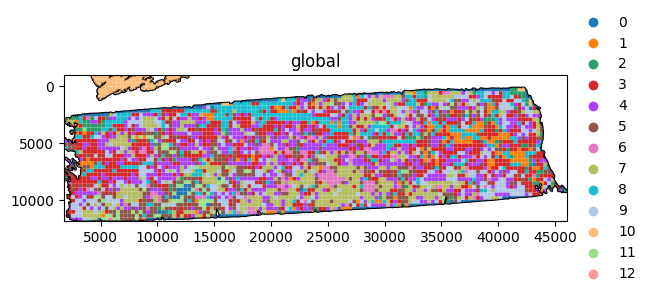

In [11]:
sdata\
    .pl.render_shapes("region_of_interest", outline_alpha=1, fill_alpha=0)\
    .pl.render_shapes("embeddings_patches", color="cluster")\
    .pl.show("global")

## Spatial join

You may be interested in joining the H&E patches and the cells. This way, you could know inside witch patch-cluster belongs each cell. This can be done with [`sopa.spatial.sjoin`](../../api/spatial/#sopa.spatial.sjoin).

In [12]:
res_gdf = sopa.spatial.sjoin(sdata, "cell_boundaries", "embeddings_patches", target_coordinate_system="global")

The resulting `GeoDataFrame` may have more columns than cells, because one cell may be inside multiple patches. We will keep only the first patch, and then save the resulting `"cluster"` column into the `sdata.tables["table"]`.

In [13]:
sdata.tables["table"].obs["cluster"] = res_gdf[~res_gdf.index.duplicated()]["cluster"].values

Here, for simplicity, we use `scanpy` to plot the cells (as dots). But we could also use `spatialdata_plot`.

We can see the cells segmented by the Xenium, colored by the H&E patch in which they belong.

In [14]:
import scanpy as sc

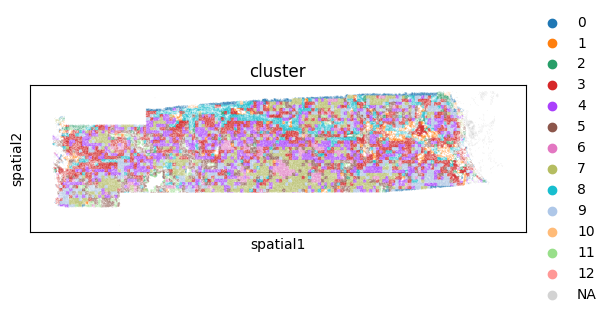

In [15]:
sc.pl.spatial(sdata["table"], color="cluster", spot_size=10)